### Clone repo

In [1]:
!git clone https://github.com/lamnguyenvu98/unsupervised-anomaly-detection.git

Cloning into 'unsupervised-anomaly-detection'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 150 (delta 67), reused 133 (delta 51), pack-reused 0
Receiving objects: 100% (150/150), 6.83 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (67/67), done.


## Setup kaggle

Upload `kaggle.json` to GDrive

In [ ]:
%%writefile /content/kaggle.sh
#!/bin/bash
if [ ! -d "/root/.kaggle" ]
then
  mkdir /root/.kaggle
fi

mv /content/drive/MyDrive/kaggle.json  --output /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json

## Install transistor dataset

*Note*: transistor dataset is a subset of mvtec-ad dataset

**Explain dataset structure:**


Here, we download 2 datasets: MVTec-AD (contains many different objects) and Transistor dataset for testing purpose

Transistor dataset should be replaced by your custom dataset.

Your custom dataset should have the following order:

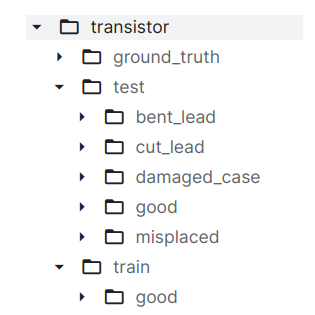

In the example above, transistor is the dataset root. It will contain a train folder and a test folder.

In the train folder, it only contains a `good` folder. `good` folder contains normal images (OK).

In the test folder, it contains good and other anomaly folders. Since, we don't care about these anomaly classes. We can specify only a anomaly folder, or whatever the name that you want. In short, test will contain `good` and `anomaly` folder. Inside of good, there are normal images. Inside of anomaly folder, there are abnormal (NG) images.

In [6]:
### Mvtech
%%capture
!bash /content/kaggle.sh
!kaggle datasets download -d ipythonx/mvtec-ad
!mkdir /content/mvtec-ad
!unzip /content/mvtec-ad.zip -d /content/mvtec-ad
!rm /content/mvtec-ad.zip

## Install project and dependencies

In [ ]:
!pip install /content/unsupervised-anomaly-detection

## Train padim and evaluate

In [5]:
%%writefile /content/padim_config.yaml
MODEL:
  INPUT_SIZE: 256
TRAIN:
  EPOCH: 50
  BATCH_SIZE: 8
  PRETRAINED: True
  DEVICE: "cuda"
  DATA_DIR: "/content/transistor"
  SAVE_DIR: "/content"
  CHECKPOINT_PATH: ""
  REDUCE_FEATURES: 100

Overwriting /content/config.yaml


In [2]:
!python /content/unsupervised-anomaly-detection/train_padim.py \
    --config /content/padim_config.yaml

Size of training set:  213
Size of testing set:  100
Optimal threshold is: 0.34250495
ROC AUC score: 0.94
Threshold:  0.34250495


## Train DFR

In [3]:
%%writefile /content/dfr_config.yaml
MODEL:
  INPUT_SIZE: 224
TRAIN:
  EPOCH: 700
  BURN_IN: 100
  BATCH_SIZE: 8
  LEARNING_RATE: 1.0e-4
  NUM_LAYERS: 16
  PRETRAINED: True
  DEVICE: "cuda"
  DATA_DIR: "/content/transistor"
  SAVE_DIR: "/content"
  RESUME_TRAIN: False
  CHECKPOINT_PATH: "/content/last.pt"

Overwriting /content/config.yaml


In [5]:
!python /content/unsupervised-anomaly-detection/train_dfr.py \
    --config /content/dfr_config.yaml

Size of training set:  213
Size of test set:  100
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100% 548M/548M [00:07<00:00, 76.4MB/s]
Compute PCA: 100% 26/26 [00:14<00:00,  1.74it/s]
Extractions shape: (4160, 5504)
Components with explainable variance 0.9 -> 403
Epoch 0 / 700
	Train Phase: 100% 26/26 [00:52<00:00,  2.03s/it, loss: 7.06760]
[RESULT] Train Loss: 7.91851

Epoch 1 / 700
	Train Phase: 100% 26/26 [00:54<00:00,  2.12s/it, loss: 7.10307]
[RESULT] Train Loss: 6.95965

Epoch 2 / 700
	Train Phase: 100% 26/26 [00:58<00:00,  2.24s/it, loss: 6.51198]
[RESULT] Train Loss: 6.70158

Epoch 3 / 700
	Train Phase: 100% 26/26 [00:57<00:00,  2.21s/it, loss: 6.25982]
[RESULT] Train Loss: 6.54961

Epoch 4 / 700
	Train Phase: 100% 26/26 [00:57<00:00,  2.21s/it, loss: 6.40565]
[RESULT] Train Loss: 6.45549

Epoch 5 / 700
	Train Phase: 100% 26/26 [00:57<00:00,  2.22s/it, loss: 6.12857]
[RESULT] Train Loss: 6.37370

E

## Train RegAD

In [10]:
%%writefile /content/regad_config.yaml
MODEL:
  INPUT_SIZE: 224
  BACKBONE: "resnet18"
  STN_MODE: "rotation_scale"
TRAIN:
  EPOCH: 50
  BATCH_SIZE: 32
  N_SHOT: 4
  N_TEST: 5
  LEARNING_RATE_STN: 1.0e-4
  LEARNING_RATE_ENC: 1.0e-4
  LEARNING_RATE_PRED: 1.0e-4
  MOMENTUM_STN: 9.0e-1
  MOMENTUM_ENC: 9.0e-1
  MOMENTUM_PRED: 9.0e-1
  PRETRAINED: True
  DEVICE: "cuda"
  TRAIN_DATA_DIR: "/content/mvtec-ad"
  TEST_DATA_DIR: "/content/mvtec-ad/transistor"
  IGNORE_CLASS: "transistor"
  SAVE_DIR: "/content"
  RESUME_TRAIN: False
  CHECKPOINT_PATH: "/content/last.pt"
INFERENCE:
  SUPPORT_SET_PATH: ""

Overwriting /content/regad_config.yaml


In [ ]:
!python /content/unsupervised-anomaly-detection/train_regad.py \
    --config /content/regad_config.yaml